# BG59：深度学习帮你识别验证码

最开始的验证码还是简单的数字，后来换成了汉字，近些年又出现低分辨率图像内容识别的验证码。对于没见过那么多类型物品或者不习惯低分辨率的朋友而言，通过验证码认证实在是一种痛苦的考验。那么机器学习能够帮助人完成这种任务吗？特别是在自动化网站信息处理的任务中，一个识别验证码的agent是重要的敲门砖，比如自动购票系统。本文只在于探讨“低分辨率验证码内容识别”这个问题，无意于指导可能存在争议的商业行为，至于使用该技术从事这些商业活动所带来的争议更与本文无关。

## 1. 问题描述

以12306火车票预定网站为例，在登录时，需要从若干个低分辨率的图像中找出包含指定物体的所有图片。通常，每一张图片中只包含一种物体，如果能够先识别出图片中所包含物体的名字，然后通过简单的字符串筛选就能找出符合要求的所有图片。

![图像识别验证码](images/bg59/12306-login-verifycode.png)

因此，这个实际问题就分成了两部分，第一识别图片内容，第二字符串匹配。问题的重点也就在图片内容的识别上。根据实际情况，我们可以认为每张图片包含一个物体，那么该物体的名字就是这个图像数据的标签。每一张图像都对应一个标签，这就可以抽象为机器学习中的分类问题，即给定一张图像，输出图像的标签，数学上的表示为
$$y=\Phi(I, \theta),$$
其中 $I$ 就是输入图像，$y$ 就是标签，$\Phi$ 表示一个机器学习模型，而 $\theta$ 就是这个机器学习模型的参数。

也就是说，只要建立了这样的一个分类的模型，就可以解决上述问题。而建立分类模型的过程也分为两步，第一步确定模型具体结构，第二步确定模型的参数。现在处理这种分类问题，一般还是使用深度学习模型。网上关于这个问题已经有了不少讨论，我们选择其中一种深度网络结构，smaller vggnet，具体如图所示。

![模型结构图](images/bg59/model-intro.png)

确定网络结构之后，剩下的问题就是求解模型参数 $\theta$，专业术语称为“训练模型”。

## 2. 训练模型

训练模型的首要任务是建立损失函数，即描述预测值与目标真值差距的函数。训练的目标就是使得差距越来越小，预测值与真值接近，从概率学上来讲，就是函数预测的概率分布与真实分布相近。由于目前的深度学习框架使用误差反传的方式计算导数，然后根据导数进行参数更新优化，因此要求损失函数可导。对于分类这种常见问题，已有成熟的损失函数，交叉熵 $H(p, q)$，数学表达式如下
$$H(p, q) = -\sum_i{p_i\log(q_i)},$$
其中 $i$ 表示类别，$p_i$ 表示输出为类别$i$的真实概率，$q_i$ 表示输出为类别 $i$ 的估计概率，整个函数就描述了预测概率分布 $q$ 与真实概率分布 $p$ 之间的接近程度。假设 $i$ 有 $N$ 种可能的取值，即有 $N$ 个类别标签，那么每个类别标签的概率分布都可以表示为一种one-hot形式的向量，即只在该类别索引处的值为 1，其他索引位置的值为 0。
接下来就可以通过最小化交叉熵来训练模型的参数。

训练模型的方法确定之后，就需要采集一些数据样本，$\{(I_k, y_k), k=1,2,3,...,n\}$。网上已经有人提供了一个包含80个类别的验证码数据集，我们对该数据集中测试集的目录稍作调整，使得数据组织结构一致，具体数据集获取方式可以查看文末github代码仓库中的介绍。

这里使用keras框架来进行模型参数的训练，对于使用NVIDIA显卡的朋友，可以使用GPU版本的tensorflow作为计算后端；对于使用AMD显卡的朋友，可以使用plaidml作为计算后端；没有安装显卡的朋友，使用CPU训练也可以。训练完成之后就可以得到训练过程中损失函数的变化图。

![训练曲线图](images/bg59/train_curve.png)

<IPython.core.display.Javascript object>


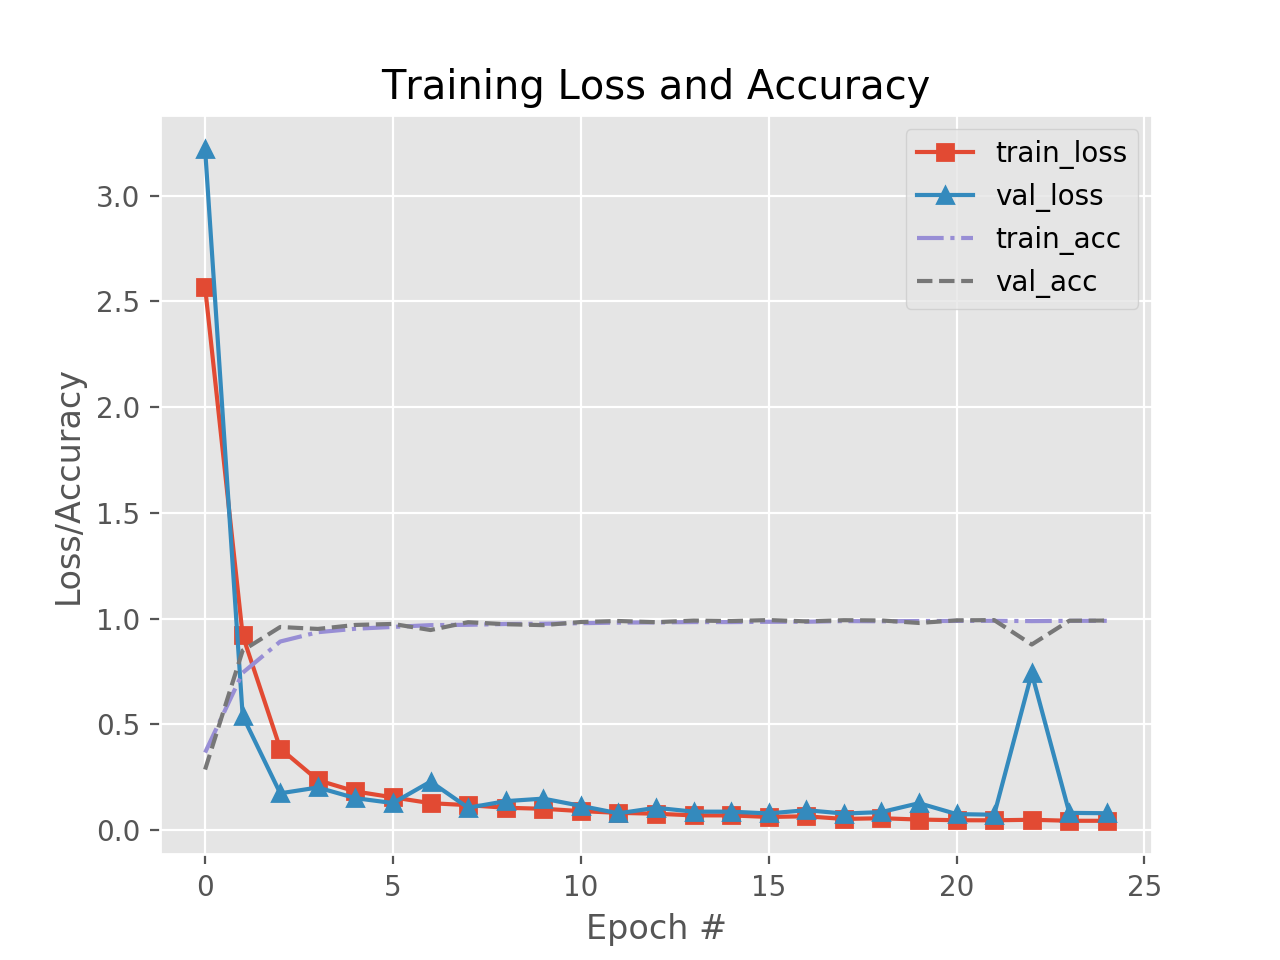

In [8]:
import pandas as pd
import matplotlib
%matplotlib notebook
import matplotlib.pyplot as plt

# read training log
log_path = '../data/bg59/training.log'
df = pd.read_csv(log_path, sep=',')
epochs = df['epoch'].values
train_loss = df['loss'].values
train_acc = df['acc'].values
val_loss = df['val_loss'].values
val_acc = df['val_acc'].values

# plot curve
plt.style.use("ggplot")
plt.figure()
plt.plot(epochs, train_loss, '-s', label='train_loss')
plt.plot(epochs, val_loss, '-^', label='val_loss')
plt.plot(epochs, train_acc, '-.', label='train_acc')
plt.plot(epochs, val_acc, '--',label='val_acc')
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper right")
plt.savefig('images/bg59/train_curve.png')

## 3. 效果测试

数据集中提供了一个100张图像组成的测试集，我们使用该测试集评估一下深度学习模型识别验证码的正确率。评估结果显示正确率为95%。事实上，还可以使用数据增强的手段进一步提供精度，不过这里就不进行测试了，留待需要使用这个模型的朋友自行添加。以上都没有提及运行速度的测试，因为对于这种低分辨率图像的分类网络运行速度一般极快，能够满足日常的使用需求，所以不单独列出数据。最后展示一些测试集上预测正确和预测错误的结果，大家可以看看在这个问题上，AI的正确率是否超过了人类。

![测试结果展示](images/bg59/test_res.png)

实验代码的github链接：https://github.com/cnbluegeek/12306verifycode